In [1]:
import pandas as pd
import spot
import os
import re
from ltlcross_runner import LtlcrossRunner, ResultsAnalyzer

In [2]:
tools = {
    'ltl2tgba': 'ltl2tgba %f > %O',
    'ltl3tela': 'ltl3tela -f %f > %O',
    'delag': 'owl ltl2dela -f %f > %O',
    'rabinizer4': 'owl ltl2dgra -f %f > %O',
}
tools_order = ['delag', 'rabinizer4', 'ltl2tgba', 'ltl3tela']
telatko = '/home/duri/phd/telatko/telatko.py'

In [3]:
patterns_ltl = 'patterns.ltl'
patterns_aut = 'patterns.csv'

In [20]:
rerun_ltl = False
rerun_aut = False

In [5]:
lcr = LtlcrossRunner(tools, formulas = [patterns_ltl], res_filename = patterns_aut)
if rerun_ltl:
    lcr.run_ltlcross(automata = True, timeout = '60')

In [6]:
ra = ResultsAnalyzer(patterns_aut)

In [7]:
ra.parse_results()

In [8]:
ltlf_translated = {}

for tool in tools_order:
    fs = ra.values.filter(items = [('acc', tool)]).dropna()
    
    ltlf_translated[tool] = len(fs[fs[('acc', tool)] > 1])
    
    fd = open('patterns-' + tool + '.hoa', 'w')
    for (ix, _), _ in fs.iterrows():
        fd.write(ra.aut_for_id(ix, tool).to_str() + '\n')
    fd.close()

In [9]:
os.environ['SPOT_TMPDIR'] = '/home/duri/phd/telatko/sat22_experiments/autcross/'
os.environ['SPOT_TMPKEEP'] = '1'

def run_autcross(tool):
    !autcross -T 300 --no-checks --csv=patterns-telatko-{tool}.csv -F patterns-{tool}.hoa 'autfilt %H > %O' '{telatko} -F %H -T 30 -L 1 -I -O %O' '{telatko} -F %H -T 30 -L 2 -I -O %O' '{telatko} -F %H -T 30 -L 3 -I -O %O' '{telatko} -F %H -T 30 -L 3 -I -G -O %O' > autcross/{tool}.log 2>&1

In [10]:
if rerun_aut:
    run_autcross('delag')

In [11]:
if rerun_aut:
    run_autcross('rabinizer4')

In [12]:
if rerun_aut:
    run_autcross('ltl2tgba')

In [13]:
if rerun_aut:
    run_autcross('ltl3tela')

In [14]:
data = {}

llre = re.compile('^Running \[A([1234])\].*\'(.*?)\'$')
hnre = re.compile('^name: "(.*)"$')
nxre = re.compile('_([TU])\\s*$')

for tool in tools_order:
    csv = pd.read_csv('patterns-telatko-' + tool + '.csv')
    log = 'autcross/' + tool + '.log'
    
    ht = {
#        'aut_id': [],
        'L0.acc': [],
        'L1.acc': [],
        'L1.time': [],
        'L1.qbfr': [],
        'L2.acc': [],
        'L2.time': [],
        'L2.qbfr': [],
        'L3.acc': [],
        'L3.time': [],
        'L3.qbfr': [],
        'L4.acc': [],
        'L4.time': [],
        'L4.qbfr': [],
    }

    #for (ix,_),_ in fs.iterrows():
    #    ht['aut_id'].append(ix)

    i = 0
    for _,r in csv.iterrows():
        ht['L' + str(i) + '.acc'].append(r['output.acc_sets'])
        if i > 0:
            ht['L' + str(i) + '.time'].append(r['time'])

        i = (i + 1) % 5
    
    logfd = open(log, 'r')
    for ll in logfd.readlines():
        lmatch = llre.match(ll)
        if lmatch:
            level = lmatch.group(1)
            hoa = lmatch.group(2)

            hoafd = open(hoa, 'r')
            aut_seen = False
            name_seen = False
            for hl in hoafd.readlines():
                if len(hl) > 3:
                    aut_seen = True
                hmatch = hnre.match(hl)
                if hmatch:
                    name_seen = True
                    xmatch = nxre.search(hmatch.group(1))
                    if xmatch:
                        ht['L' + level + '.qbfr'].append(xmatch.group(1))
                    else:
                        ht['L' + level + '.qbfr'].append('U')
                    break

            hoafd.close()

            if not aut_seen:
                ht['L' + level + '.qbfr'].append('X')
            elif not name_seen:
                ht['L' + level + '.qbfr'].append('U')

    logfd.close()

    #for k in ht:
    #    print(tool, k, len(ht[k]))
    data_dd = pd.DataFrame(data = ht)
    data_de = data_dd.dropna()
    data_df = data_de[(data_de['L1.qbfr'] != 'X') & (data_de['L2.qbfr'] != 'X') & (data_de['L3.qbfr'] != 'X') & (data_de['L4.qbfr'] != 'X') & (data_de['L0.acc'] > 1)]
    data[tool] = data_df

In [15]:
sumdata = {
    'tool': [],
    'ltlcount': [],
    'autcount': [],
    'L0.acc': [],
}
for l in range(1, 5):
    for s in ['acc', 'time', 'ratio', 'qbft', 'qbfu']:
        sumdata['L' + str(l) + '.' + s] = []

for tool in tools_order:
    data_df = data[tool]
    
    sumdata['tool'].append(tool)
    sd = data_df.sum()
    sumdata['ltlcount'].append(ltlf_translated[tool])
    sumdata['autcount'].append(len(data_df))
    for i in range(0, 5):
        sumdata['L' + str(i) + '.acc'].append(int(sd['L' + str(i) + '.acc']))
        if i > 0:
            t = sd['L' + str(i) + '.time']
            #if i > 1 and i < 4:
            #    t -= sd['L' + str(i - 1) + '.time']
            sumdata['L' + str(i) + '.time'].append(round(t, 1))
            sumdata['L' + str(i) + '.ratio'].append(
                round(100 - 100 * int(sd['L' + str(i) + '.acc']) / int(sd['L0.acc']), 1)
            )
            
            for x in ['T', 'U']:
                sumdata['L' + str(i) + '.qbf' + x.lower()].append(len(data_df[data_df['L' + str(i) + '.qbfr'] == x]))

#for k in sumdata:
#    print(k, len(sumdata[k]))
r = pd.DataFrame(data = sumdata)
r

,tool,ltlcount,autcount,L0.acc,L1.acc,L1.time,L1.ratio,L1.qbft,L1.qbfu,L2.acc,...,L3.acc,L3.time,L3.ratio,L3.qbft,L3.qbfu,L4.acc,L4.time,L4.ratio,L4.qbft,L4.qbfu
0,delag,162,158,667,487,1148.9,27.0,25,133,492,...,499,1701.5,25.2,38,120,479,3521.4,28.2,34,124
1,rabinizer4,274,274,1084,706,1213.1,34.9,25,249,716,...,716,1766.9,33.9,34,240,695,3707.9,35.9,33,241
2,ltl2tgba,89,81,246,246,640.7,0.0,0,81,246,...,237,1101.5,3.7,8,73,237,1170.3,3.7,7,74
3,ltl3tela,108,107,463,447,932.8,3.5,22,85,449,...,441,1183.9,4.8,29,78,438,2973.9,5.4,29,78


### Output

In [16]:
fd = open('../paper/table-data.tex', 'w')

print('''
\\begin{tabular}{ccccccc}                                                        
\\toprule                                                                        
automata set & level & marks & reduction [\\%] & time [s] & \\makecell{solver \\\\ response} & \\makecell{solver \\\\ timeout} \\\\
''', file=fd)

tool_name = ['ltl2dela', 'ltl2dgra', 'ltl2tgba', 'ltl3tela']
for tool_ix in range(0, 4):
    print('\\midrule', file=fd)
    print('\\multirow{4}{*}{\\makecell{\\texttt{' + tool_name[tool_ix] + '}\\\\'
          + str(r.loc[tool_ix, 'autcount']) + '/'
          + str(r.loc[tool_ix, 'ltlcount']) + ' solved aut.\\\\'
          + str(r.loc[tool_ix, 'L0.acc']) + ' acc.~marks}}', file=fd)
    for level in range(1, 5):
        print('&', file=fd)
        if level == 4:
            print('multi &', file=fd)
        else:
            print('level ' + str(level) + ' &', file=fd)
        print(' & '.join([str(r.loc[tool_ix, 'L' + str(level) + '.' + k]) for k in ['acc', 'ratio', 'time', 'qbfu', 'qbft']]), file=fd)
        print('\\\\', file=fd)

print('''
\\bottomrule                                                                     
\\end{tabular}
''', file=fd)
        
fd.close()

In [17]:
fd = open('../paper/quantile.tex', 'w')

tool_name_pretty = {
    'ltl2tgba': 'ltl2tgba',
    'ltl3tela': 'ltl3tela',
    'delag': 'ltl2dela',
    'rabinizer4': 'ltl2dgra',
}

tool_color = {
    'ltl2tgba': 'blue',
    'ltl3tela': 'red',
    'delag': 'green',
    'rabinizer4': 'orange',
}

print('''
\\begin{tikzpicture}
\\begin{axis}[
   ymode=log,
   height=8cm,
   width=12cm,
   grid=major,
   %legend style={ at={(1,1)}, anchor=north west },
   legend pos=north west,
]
''', file=fd)

for tool in tools_order:
    l = sorted(list(data[tool]['L4.time']))
    print('\\addplot[mark = none, draw = ' + tool_color[tool] + '] coordinates {', file=fd)
    print('\n'.join([ '\t(' + str(i) + ', ' + str(l[i]) + ')' for i in range(0, len(l)) ]), file=fd)
    print('};\n\\addlegendentry{\\texttt{' + tool_name_pretty[tool] + '}}', file=fd)
"""
%\addplot coordinates {
%   (1, 0.3)
%   (2, 0.8)
%   (3, 1.5)
%   (4, 2.7)
%   (5, 3.9)
%   (6, 4.1)
%};
\addlegendentry{Delag}
"""


print('''
\\end{axis}
\\end{tikzpicture}
''', file=fd)

fd.close()

In [18]:
fd = open('../paper/table-heatmap.tex', 'w')

irange = list(range(2, 11)) + [15, 20]
jrange = list(range(0, 11)) + [15, 20]

tabu = {}
tabt = {}
for i in irange:
    tabu[i] = {}
    tabt[i] = {}
    for j in jrange:
        tabu[i][j] = 0
        tabt[i][j] = 0
for tool in tools_order:
    d = data[tool].dropna()
    for before,after,qbf in zip(d['L0.acc'], d['L4.acc'], d['L4.qbfr']):
        b = int(before)
        if b > 10:
            b = 5 * int(b / 5)
        a = int(after)
        if a > 10:
            a = 5 * int(a / 5)
        if qbf == 'T':
            tabt[b][a] += 1
        else:
            tabu[b][a] += 1

print('''
\\begin{tabular}{cc|ccccccccccc|}
\\cline{3-13}
\\vspace{-12pt}\\\\
\\multirow{13}{*}{\\rotatebox[origin=c]{90}{acc.~marks after the reduction}\\hspace{5pt}}
''', file=fd)

for a in reversed(jrange):
    print(' & ', file=fd)
    print(str(a) + '--' + str(a + 4) if a >= 10 else str(a), file=fd)
    for b in irange:
        print(' & ', file=fd)
        
        s = tabu[b][a] + tabt[b][a]
        plust = '+' + str(tabt[b][a]) if tabt[b][a] > 0 else ''
        if s > 0:
            out = '\\textbf{' + str(tabu[b][a]) + plust + '}'
        elif a <= b:
            out = '0'
        else:
            out = ''
        
        if s > 0:
            color = int(s / 3) + 5
            if color > 0:
                if color > 50:
                    out = '\\textcolor{black!10}{' + out + '}'
                out = '\\cellcolor{blue!' + str(color) + '}' + out
        
        print('\\footnotesize{' + out + '}', file=fd)
    print('\\\\', file=fd)

print('\\cline{3-13}\\vspace{-10pt}\\\\', file=fd)
print('\\multicolumn{2}{c}{}', file=fd)
for b in irange:
    print(' & ', file=fd)
    xn = str(b) + '--' + str(b + 4) if b >= 10 else str(b)
    if b == 20:
        xn = '\\multicolumn{1}{c}{' + xn + '}'
    print(xn, file=fd)
    
print('''
\\\\
\\vspace{-10pt}\\\\
\\multicolumn{2}{c}{} & \\multicolumn{11}{c}{acc.~marks before the reduction} \\\\
\\end{tabular}
''', file=fd)
    
fd.close()

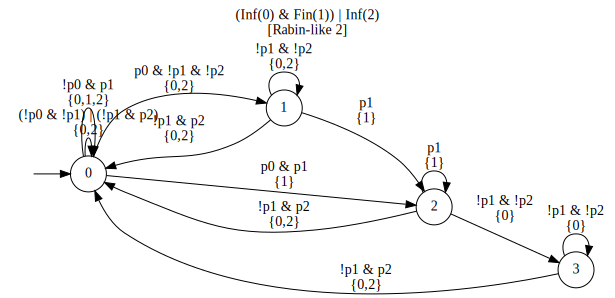

In [19]:
ra.aut_for_id(265, 'delag')